In [7]:
! ls train_output

999.pkl  999epochs_L2_on_activations.pk1  999epochs_no_reg_on_activations.pk1


In [1]:
import utils
import torch
from models import GAT, SpGAT
import torch.nn.functional as F
import sklearn.metrics
import numpy as np
from torch.autograd import Variable
import pandas as pd

In [2]:
adj, features, labels, idx_train, idx_val, idx_test = utils.load_joshi_data("Cd8a")
features, adj, labels = Variable(features), Variable(adj), Variable(labels)

 loading from cache file../data/graphs/stringdb_mouse_graph_all_edges.adjlist


In [3]:
features.shape

torch.Size([1630, 308, 1])

In [4]:
model = GAT(ncells = features.shape[0], #features is cells x gene x gene features
                ngenes=features.shape[1], 
                nfeat=features.shape[2],
                nhid=1, 
                nclass=1, # regression
                dropout=0.6, 
                nheads=1, 
                alpha=0.2)

model

GAT(
  (out_att): GraphAttentionLayer (1 -> 1)
)

In [5]:
list(model.parameters()) # optmized in AdamOptimizer

[Parameter containing:
 tensor([[-1.9303]], requires_grad=True),
 Parameter containing:
 tensor([[-0.0374, -0.0064],
         [-0.0589, -0.0508],
         [ 0.0338, -0.0469],
         ...,
         [ 0.0751,  0.0076],
         [-0.0154, -0.0668],
         [-0.0391,  0.0413]], requires_grad=True)]

In [8]:
torch.load('train_output/999.pkl')

OrderedDict([('out_att.W', tensor([[3.6918]], device='cuda:0')),
             ('out_att.a',
              tensor([[-0.0235, -0.0529],
                      [ 0.0041,  0.0772],
                      [-0.0483,  0.0020],
                      ...,
                      [ 0.0261,  0.0732],
                      [-0.0199,  0.0706],
                      [ 0.0097,  0.0420]], device='cuda:0')),
             ('out_att.Z',
              tensor([[[0.5163, 0.8571, 0.1391,  ..., 0.1931, 0.2191, 0.9192]],
              
                      [[0.2689, 0.4486, 0.9187,  ..., 0.3406, 0.0054, 0.2712]],
              
                      [[0.5597, 0.4874, 0.3382,  ..., 0.0273, 0.9110, 0.5904]],
              
                      ...,
              
                      [[0.3275, 0.7009, 0.4747,  ..., 0.8666, 0.7349, 0.6622]],
              
                      [[0.1789, 0.9989, 0.6871,  ..., 0.9499, 0.8603, 0.8685]],
              
                      [[0.2618, 0.6337, 0.4216,  ..., 0.8440, 0.6

In [7]:
model.load_state_dict(torch.load('train_output/999.pkl'))

<All keys matched successfully>

In [7]:
def compute_test():
    model.eval()
    output, attention = model(features, adj)
    output = output.reshape(-1)
    loss_test = F.smooth_l1_loss(output[idx_test], labels[idx_test].float()).float()
    r2_test = sklearn.metrics.r2_score(labels[idx_test].cpu(), output[idx_test].cpu().detach().numpy())
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.data.item()),
          "r2_test= {:.4f}".format(r2_test))
    
    return (output, labels, attention)

In [8]:
output, labels, attention = compute_test()

Test set results: loss= 0.8454 r2_test= -58.1709


In [9]:
output

tensor([-0.4288, -0.4381, -0.4138,  ..., -0.4498, -0.3446, -0.3445],
       grad_fn=<ViewBackward>)

In [10]:
labels

tensor([1.2721, 1.3539, 1.1057,  ..., 0.7352, 0.8688, 0.9314])

In [15]:
torch.norm(attention, 0) / (attention.shape[0])

tensor(307., grad_fn=<DivBackward0>)

In [12]:
1 / 175

0.005714285714285714

In [19]:
pd.read_pickle("../data/joshi_processing/week8_ln_notebook_state.pkl")

<module '__main__'>

In [16]:
idx_test_mask = [True if l in idx_test.numpy() else False for l in range(labels.shape[0])]

In [17]:
ensembl_Cd8a = "ENSMUSG00000053977"

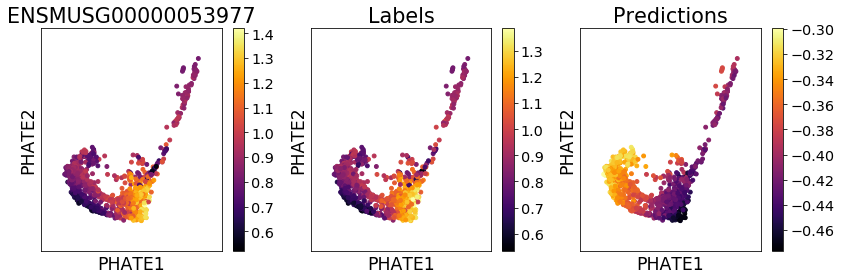

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc, ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt, exact_word=ensembl_Cd8a), 
                     title=ensembl_Cd8a, ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc, ax=axes[1],fontsize=12, s=15, 
                      c=labels.detach().numpy(), title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc, ax=axes[2],fontsize=12, s=15, 
                      c=output.detach().numpy(), title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()

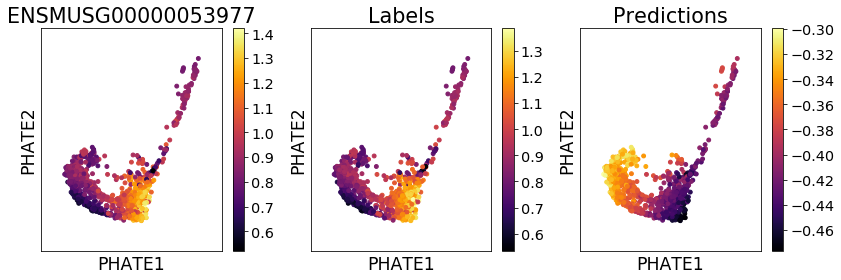

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
scprep.plot.scatter2d(data_phate_pc[idx_test_mask], ax=axes[0],fontsize=12, s=15, 
                      c=scprep.select.select_cols(data_magic_filt[idx_test_mask], exact_word=ensembl_Cd8a), 
                     title=ensembl_Cd8a, ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[idx_test_mask], ax=axes[1],fontsize=12, s=15, 
                      c=labels.detach().numpy()[idx_test_mask], title="Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(data_phate_pc[idx_test_mask], ax=axes[2],fontsize=12, s=15, 
                      c=output.detach().numpy()[idx_test_mask], title="Predictions",
                      ticks=False, label_prefix="PHATE")
plt.tight_layout()